# 7. 一般化線形混合モデル(GLMM) -個体差のモデリング-

* 「GLMではうまく説明できない」現象をうまく扱えるようにGLMを強化する。

Q. 一般化線形モデル(GLM)とはなんだったか？

A.
* 確率分布、リンク関数、線形予測子を組み合わせて、応答変数$y_i$と説明変数$x_i$を関連づけるシステム

* しかし、単純なGLMでは現実のデータ解析に応用できない。
* 理由は、実験・調査で得られたカウントデータのばらつきは、ポアソン分布や二項分布**だけ**ではうまく説明できないから。

* 例えば、植物個体の種子数の調査。説明変数がどの個体でも同じ値だとしても、現実の生物では「説明変数以外は全部均質」といった条件は満たされないため、平均$\lambda$の値が全個体共通とはならないだろう。
* 「説明変数が同じなら平均も同じ」というGLMの仮定が成立しないので、集団全体の種子数の分布はポアソン分布で期待されるよりも大きくばらつく

* この話の要点は「データにばらつきをもたらす『個体間の差異』なるものを、定量化できない」ということ。
* 人間は自然の全てを測定できるわけではない。
* しかし「何か原因不明な個体差がある」ことは統計モデルとして表現できる。

Q. 一般化線形混合モデル(generalized linear mixed model,GLMM)とは？

A.
* 「人間が測定できない・測定しなかった個体差」を組み込んだGLM
* 複数の確率分布を部品とする統計モデル。
    * 例えば、データのばらつきは、二項分布・ポアソン分布、個体のばらつきは正規分布など。
* 多くの実際のデータ解析ではこれを用いるのが良い

Q. 個体差、場所差とは？

A.
* 観測者がデータ化していないけれど、個体や調査地に由来する原因不明の差異

## 7.1. 例題：GLMでは説明できないカウントデータ

* 架空植物の各個体から8個の種子を取ってきて、そのうち幾つが生存しているかを調べたとする。
* データ解析の目的：生存種子数が葉数とともにどのように増大するのかを解明すること

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

d = pd.read_csv("data7.csv")

/Users/takizawa/dev/python/books/midori/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
d.head()

,N,y,x,id
0,8,0,2,1
1,8,1,2,2
2,8,2,2,3
3,8,4,2,4
4,8,1,2,5


In [5]:
d.describe()

,N,y,x,id
count,100.0,100.000000,100.000000,100.000000
mean,8.0,3.810000,4.000000,50.500000
std,0.0,3.070534,1.421338,29.011492
min,8.0,0.000000,2.000000,1.000000
25%,8.0,1.000000,3.000000,25.750000
50%,8.0,3.000000,4.000000,50.500000
75%,8.0,7.000000,5.000000,75.250000
max,8.0,8.000000,6.000000,100.000000


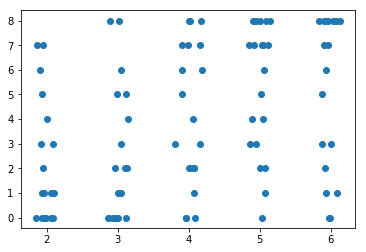

In [11]:
# そのまま散布図にすると点が重なってしまい数の多さがわからないため、
# 正規分布のズレを加えている。
d["x_bure"] = np.random.normal(loc=0,scale=0.1,size=100)
plt.scatter(d.x+d.x_bure,d.y)

* 第6章と同じように、GLMを使って、データから種子の生存確率を推定してみる。

### GLMのあてはめ

* 「$N$個のうち$y$個が生存していた」といった構造のカウントデータは二項分布を用いる。
* 二項分布を使ったGLMの一つであるロジスティック回帰の統計モデルを用いる。
* ロジスティック回帰ではリンク関数はロジットリンク関数。

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.glm('y + I(N-y)~ x',data=d,family=sm.families.Binomial())

In [13]:
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -322.80
Date:                Wed, 28 Jun 2017   Deviance:                       513.84
Time:                        23:52:57   Pearson chi2:                     53.5
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1487      0.237     -9.057      0.000      -2.614      -1.684
x              0.5104      0.056      9.179      0.000       0.401       0.619
==============================================================================
"""

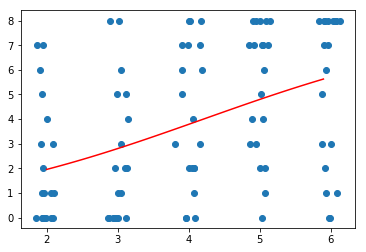

In [16]:
df_test = pd.DataFrame()
df_test["x"]=np.arange(2,6,0.1)
plt.scatter(d.x+d.x_bure,d.y)
plt.plot(df_test.x,result.predict(df_test)*8,c="red")

* 真のモデルと異なる結果となった。
* 改めて、データを確認してみよう。$x_i=4$である20個体の生存種子数は下記。

In [17]:
d[d.x == 4].groupby([d.y]).count()["N"]

y
0    3
1    1
2    4
3    2
4    1
5    1
6    2
7    3
8    3
Name: N, dtype: int64

### 図7.3.(B)を作成する（できてない）

In [66]:
from collections import Counter
df_test_2 = pd.DataFrame()
df_test_2["x"]= np.array([4])
p = result.predict(df_test_2)
# binomi = np.random.binomial(n=8,p=p,size=10000)
# ys,counts = zip(*Counter(binomi).items())
# indexes=np.arange(len(ys))

In [ ]:
import scipy.misc as scm
p_list = list()
for i in range(9):
    p_list.append(scm(8,i,1)*)

(0, 6)

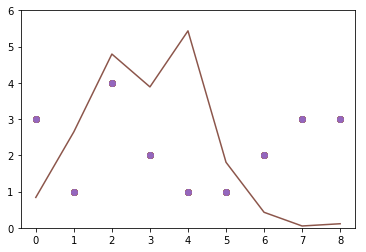

In [67]:
plt.plot(d[d.x == 4].groupby([d.y]).count()["N"].index,d[d.x == 4].groupby([d.y]).count(),"o")
plt.plot(indexes,np.array(counts)/500,)
plt.ylim(0,6)

* 見て見ると二項分布に従ってはいないようだ。

## 7.2 過分散と個体差

* 「N個のうちy個が生存した」というカウントデータを扱っているのに、そのばらつきが二項分布で説明できないように見える。
* 二項分布で期待されるよりも大きなばらつきを過分散（または過大分散,overdispresion)と言う。

### 7.2.1. 過分散：ばらつきが大きすぎる

* 葉数$x_i=4$の個体の生存種子数のデータが、どのように「二項分布に合っていない」のかを調べる。

In [8]:
d_4 = pd.DataFrame()
d_4 = d[d.x==4]
# d_4["seizon"] = d[d.x == 4].groupby([d.y]).count()["N"].index
# d_4["samplesuu"] = d[d.x == 4].groupby([d.y]).count()["N"].values

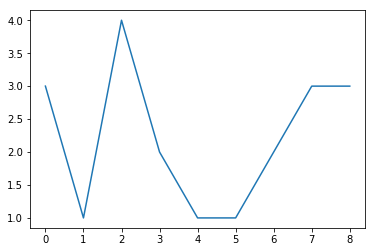

In [10]:
plt.plot(d[d.x == 4].groupby([d.y]).count()["N"].index,d[d.x == 4].groupby([d.y]).count()["N"].values)

* 平均と分散を調べる。

In [12]:
d_4.head()

,N,y,x,id
40,8,6,4,41
41,8,2,4,42
42,8,0,4,43
43,8,5,4,44
44,8,6,4,45


In [13]:
d_4.y.describe()

count    20.000000
mean      4.050000
std       2.892367
min       0.000000
25%       2.000000
50%       3.500000
75%       7.000000
max       8.000000
Name: y, dtype: float64

In [23]:
d_4.y.describe()["std"]**2

8.3657894736842131

In [24]:
# heikin = (d_4.seizon * d_4.samplesuu).sum() / d_4.samplesuu.sum()
# heikin
# (((d_4.seizon - heikin) ** 2) * d_4.samplesuu).sum()/d_4.samplesuu.sum()

* (よくわからない。）生存確率の平均は$4.05/8=0.5$ぐらい。二項分布に従うのであれば、その分散は、$8\times0.5\times(1-0.5)=2$ぐらいとなるはず（よくわからない）。上記だと分散は$8.37$となっており比較的大きくなっている。
* このデータは二項分布と呼ぶには「ばらつきが大きすぎる」ので、二項分布を使っては説明できないだろうということです。

### 7.2.2. 観測されていない個体差がもたらす過分散

* 単純な二項分布モデルからのずれの原因の一つとして、観測されていない個体差があげられる。
* 個体差があれば過分散は生じうる。
* 過分散は現象の状態を記述しているのではなく、統計モデリングしている人間の錯誤を表している。
    * 「この個体たちは皆均質」という過程を設け、「二項分布で説明できう」と期待したのに、失敗した、ということ。

### 7.2.3. 観測されていない個体差

Q. 個体差とは？

A.
* データとしては定量化も識別もされていないけれど、「各個体（観測の単位）の何かに起因している様に見える差」

---

* 個体差をもたらしうる要因は少なくとも2種類ある
* 生物的な要因
    * 個体の遺伝子、年齢や過去に経験した履歴の相違
* 非生物的な要因
    * 生育環境の微妙な違い
    * 非生物的な局所環境の影響のことを、この本では場所差、あるいはブロック差と呼ぶ。

Q. 個体差、場所差は識別できるか？

A.
* 例えば、1個体ずつ植木鉢に植えている場合、その個体差と植木鉢の差は識別できない。

---

* 個体に影響を与えている要因すべてを定量・特定することは不可能。個体差や場所差を原因不明のまま、統計モデルを作る必要がある。

## 7.3. 一般化線形混合モデル

Q. 一般化線形混合モデル（GLMM）とは？

A.
* 個体差や場所差の効果をGLMに組み込んだ統計モデル

---

### 7.3.1.個体差を表すパラメータの追加

* 架空植物の種子の生存確率$q_i$を表す式に、個体$i$の個体差を表すパラメーター$r_i$を追加する。
 $$
 logit(q_i) = \beta_1+\beta_2 x_i + r_i
 $$

* 「観測されていない個体差などない」と仮定しているGLMは、種子数を調査した全個体で$r_i=0$と設定していることになる。

### 7.3.2. 個体差のばらつきを表す確率分布

Q. GLMMの特徴は？

A.
* 個体差を表すパラメーター{$r_1,r_3,\cdots,r_{100}$}が何か確率分布に従っていると仮定するところ。

---

* ここではとりあえず、個体差$r_i$は平均0で標準偏差$s$の正規分布に従うと仮定して見る。正規分布である根拠は何もなく、どの様な確率分布に従うかわからないが、便利なのでそうする。
* 各個体の$r_i$は個体間で相互に独立した確率変数であると仮定すると、確率密度関数は下記。
$$
p(r_i | s)= \frac {1} {\sqrt {2\pi s^2}} \exp \left(- \frac {r_{i}^2} {2s^2}\right)
$$
* 確率密度$p(r_i|s)$は$r_i$の「出現しやすさ」を表している。
    * $r_i$が$0$に近い個体はわりと「ありがち」。絶対値が大きな個体は「あまりいない」
    
* 標準偏差$s$は「集団内の$r_i$のばらつき」を表している。
    * $s$が大きければ大きいほど、個体差は大きくなり、過分散がひどくなる。

### 7.3.3. 線形予測子の構成要素：固定効果とランダム効果


Q. 一般化線形 **混合** モデル（GLMM)という名前の「混合」とは何か？

A.
* 線形予測子に、固定効果とランダム効果の表す項を持っているもの。

---

* 固定効果とランダム効果といった分類はわかりにくい。パラメーターにはデータのかなり広い範囲を説明する大域的なものと、ごく一部だけを担当している局所的なものがあると整理して統計モデルを作るのが良いかも。

## 7.4. 一般化線形混合モデルの最尤推定

* GLMMに含まれている個体差$r_i$は最尤推定できない。
* 理由は、{$r_1,r_2,\cdots,r_{100}$}の100個のパラメーターと、{$\beta_1,\beta_2,s$}の3個のパラメーター合わせて103個を100個のデータから推測するのはナンセンス。
* この様な場合の対応策の1つが、**個体ごとの尤度**$L_i$の式の中で、$r_i$を積分すること。（それ以外の対応策は8章で扱う）
$$
L_i = \int_{-\infty}^{\infty} p(y_i|\beta_1,\beta_2,r_i) p(r_i|s)dr_i
$$
* この様にすると、尤度から$r_i$は消えてしまう。
    * 色々な$r_i$の値における尤度を評価し、その期待値の算出をしている。
* 尤度$L_i$を評価するときに、二項分布$p(y_i|\beta_1,\beta_2,r_i)$と正規分布をかけて$r_i$で積分する操作は、「2種類の分布を混ぜていること」に相当。
* 無限個の二項分布を混ぜることで、平均よりも分散の大きい過分散な確率分布を作り出せる。
    * サンプルサイズは有限個だが、無限個の二項分布を混ぜる。

* 確率分布を混ぜて新しい確率分布を作る、というのは、統計モデル作りの基本的な技法の1つ
* 全データの尤度は$L_i$の100個体分の積なので、$$L(\beta_1,\beta_2,s)=\prod_i L_i$$
* 個体差$r_i$がどこにも入っていない対数尤度$\log L(\beta_1,\beta_2,s)$が最大になる様なパラメータ$\beta_1,\beta_2,s$の最尤推定値を探すことになる。

* （自分が理解してないので、推薦できるがわからないが、）線形混合モデルの可視化
http://qiita.com/kenmatsu4/items/da59a6fccde0cee4ef49

### 7.4.1. Rを使ってGLMMのパラメーターを推定

* PythonにはGLMMのライブラリがない模様。
* Chap7_4_1を参照

## 7.5. 現実のデータ解析にはGLMMが必要

Q. GLMMの様な考え方が必要になるかどうかの判断ポイントは？

A. 
* 同じ個体・場所などからなんどもサンプリングしているか
* 個体差や場所差が識別できてしまう様なデータのとり方をしているか

### 7.5.1. 反復・擬似反復と統計モデルの関係

* 個体差・場所差をどの様に統計モデルに組み込むかの方法は、「データをどのように取ったのか」に依存している。
* 個体差・場所差が「見えてしまう」データの取り方をしているのかどうかが重要。

#### 具体例
* 植木鉢で育てられた植物から種子を取って生死を調べたとする。


#### 各植木鉢に1つの個体、各個体で一つだけ種子の生死を調べた場合(図7.11(A))

* 過分散生じない。
* 個体差のばらつきも推定できない。
* 個体差と植木鉢の区別がつかない。
* このようなデータの取り方をすれば、統計モデルに個体差・場所差を入れようがない（？）ので、GLMMを使えない。
* GLMで推定して問題ない
* （滝沢コメント）同じ$x_i$でも、種子の生存数のばらつきが大きい場合、それはその植物において、$x_i$が説明変数として妥当でない、ということになる（？）

* このようなデータの取り方を「**反復**」、あるいは「独立した反復」と呼ぶ。

Q. 反復をとる目的は？

A.
* データから個体差・場所差の効果を除去し、GLMで推定するなど、統計モデルを簡単にすること。

#### 各植木鉢に1つの個体、各個体から複数の種子の生死を調べた場合(図7.11(B))

* 同じ個体から複数の種子を調べると、「この個体では種子がやたらと死んでいる」「こっちの個体は同じ$x_i$だけれど、生存確率が高いようだ」と言った事がデータから読み取れる。
* 個体差を入れたGLMMを使えば、「個体差のばらつき」$s$が推定される。

* 「個体から複数のデータを取る」という実験操作は「**擬似反復**」。「反復」に見えるが、個体差などを打ち消す反復になっていない。
* 個体差が推定可能。個体差の影響を考慮しなければ、推定結果に偏りが生じる。
* GLMMが必要。
* 植木鉢は反復になっていて、個体に差があるのか植木鉢に差があるのか区別ができないので、植木鉢差だけを分離して推定できない。（上記の「個体差」に「植木鉢差」も含まれている。

#### 各植木鉢に複数の個体、各個体から1つだけ種子の生死を調べた場合(図7.11(C))

* 個体は反復

* 植木鉢には複数の個体が入っているため、「こっちの植木鉢では死亡確率が高い」といった事が推定可能。

#### 各植木鉢に複数の個体、各個体から複数の種子の生死を調べた場合(図7.11(D))

* 個体も植木鉢も擬似反復。
* 種子の生存確率は
$$
logit(q_i) = \beta_1+ \beta_2 x_i + r_i + r_j
$$
* 個体差・場所差を考慮しつつ、$\beta_1$,$\beta_2$に加えて、個体差・場所差それぞれのばらつきの大きさを最尤推定するのは、数値計算の問題としては難しい。
* このような時にはGLMMと最尤推定の組み合わせではなく、階層ベイズモデルとMCMCを使って統計モデルをデータに当てはめます(次章)
* 擬似反復を正しく統計モデリングすれば、個体差・場所差を定量化できる。

## 7.6. 色々な分布のGLMM

* ポアソン分布
    * 正規分布と混ぜ合わせる事が多い
    * ガンマ分布と混ぜ合わされた、負の二項分布
* 観測データのばらつきが正規分布やガンマ分布である時には過分散を定義することはできない。
    * これらの確率分布は平均とは独立に分散を決められる
        * 分散が大きければ、正規分布・ガンマ分布の中で、分散を大きくすれば良い（？）。
* GLMMが必要になるかどうかの本質は、過分散の有無ではなく、「1個体から何度もデータを取る」ような擬似反復が含まれているかどうかで決まる。
* データのばらつきが正規分布やガンマ分布である時にも、サンプリングが擬似反復になっている可能性がある場合には、GLMMのように、個体差・場所差を考慮したモデルを当てはめなければならない。
* 分布は正規分布で恒等リンク関数とする統計モデルは線形混合モデルと呼ばれる事がある。

## 7.7. この章のまとめと参考文献

* 「観測されなかった個体差」を組み込んだGLMである、一般化線形混合モデル(GLMM)を扱った。
* GLMがあてはまらない場合がある。
* それは「説明変数が同じならどの個体も均質」と仮定していたGLMが誤り。個体差があり、実際には二項分布で期待されるより過分散。
* GLMMは線形予測子に個体差のばらつき$r_i$を追加し、全個体の$r_i$がある確率分布に従うと仮定した統計モデル。
* 積分によって$r_i$を消去した尤度を最大化する事で、GLMMの$beta$,$r_i$のばらつきといった、大域的なパラメータを最尤推定できる。
* 擬似反復(一つの個体から複数データ、一つの場所に多数の個体）では、個体差・場所差を組み込んだGLMMが必要。
* データのばらつきを表す確率分布に依らず、個体差・場所差に影響されるデータであれば、これらの効果をランダム効果として組み込んだ統計モデルで推定しなければならない。

* 「人間には観測できなかった・できない、しかし観測データにばらつきをもたらす」要因を組み込んだ統計モデリングは重要。
* 個体差＋場所差の統計モデル（第10章）
* 空間相関のある場所差を考慮した統計モデル(第11章）